In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('/Users/danielburns/Library/CloudStorage/Box-Box/my_scripts')
from TSenCA.ContactAnalysis.ContactFrequencies import *
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

In [2]:
# getcontacts frequency files are all in here
frequency_dir = 'data/getcontacts_frequency_files'
# list them
frequency_files = [f'{frequency_dir}/{file}' for file in os.listdir(frequency_dir)]
# Now turn all the frequency data into a dictionary where each key is a contact id and
# each value is a list of contact frequencies across all the simulated temperatures
frequency_files.sort()
contact_frequency_dictionary = make_contact_frequency_dictionary(frequency_files)
# Now put this into a dataframe that the ContactFrequency class accepts
cont = ContactFrequencies(pd.DataFrame(contact_frequency_dictionary))

In [20]:
test = pd.read_csv(frequency_files[0],sep='\t',usecols=[0,1,2],skiprows=[0,1],header=None,names=['res1','res2','freq'],index_col=None)

In [26]:
test.loc[0]['res1']

'C:THR:680'

In [30]:
all_data = {}

for i, frequency_file in enumerate(frequency_files):
    test = pd.read_csv(frequency_file,sep='\t',usecols=[0,1,2],skiprows=[0,1],header=None,names=['res1','res2','freq'],index_col=None)
    for row in test.index:
        res1, res2, freq = test.loc[row]['res1'], test.loc[row]['res2'], test.loc[row]['freq']
        if f'{res1}-{res2}' not in all_data.keys():
            all_data[f'{res1}-{res2}'] = [0 for j in range(i)]
            all_data[f'{res1}-{res2}'].append(freq)
        else:
            extend_length = i - len(all_data[f'{res1}-{res2}'])-1
            all_data[f'{res1}-{res2}'].extend([0 for j in range(extend_length)])
            all_data[f'{res1}-{res2}'].append(freq)
for freq_list in all_data.values():
    if len(freq_list) != i+1:
        extend_length = i - len(all_data[f'{res1}-{res2}'])
        freq_list.extend(0 for j in range(extend_length))

In [29]:
test_cont = pd.DataFrame(all_data)
test_cont

ValueError: All arrays must be of the same length

In [3]:
# TRPV3 is a homotetramer so you can average the contact frequencies from all 4 subunits
# this will give better statistics on the contacts and simplify analysis
# adding a structure file is a good idea on a multimer so that when you go to visualize it,
# the correct contact pair is depicted.
avg_df = cont.average_contacts(structure='data/TRPV3_structure.pdb')
# pore contacts that occur between opposing subunits will print

got more contacts than identical subunits for contact matching A:LEU:639-B:GLY:638: ['A:GLY:638-B:LEU:639', 'B:GLY:638-C:LEU:639', 'C:GLY:638-D:LEU:639', 'A:GLY:638-D:LEU:639', 'A:GLY:638-C:LEU:639', 'B:GLY:638-D:LEU:639']
got more contacts than identical subunits for contact matching A:ILE:674-B:ILE:674: ['B:ILE:674-C:ILE:674', 'A:ILE:674-B:ILE:674', 'A:ILE:674-D:ILE:674', 'C:ILE:674-D:ILE:674', 'A:ILE:674-C:ILE:674', 'B:ILE:674-D:ILE:674']
got more contacts than identical subunits for contact matching A:LEU:639-B:GLY:640: ['A:LEU:639-D:GLY:640', 'A:LEU:639-C:GLY:640', 'C:LEU:639-D:GLY:640', 'A:LEU:639-B:GLY:640', 'B:LEU:639-C:GLY:640', 'B:LEU:639-D:GLY:640']
got more contacts than identical subunits for contact matching A:GLY:640-B:ASP:641: ['A:ASP:641-B:GLY:640', 'C:ASP:641-D:GLY:640', 'B:ASP:641-C:GLY:640', 'B:ASP:641-D:GLY:640', 'A:ASP:641-D:GLY:640', 'A:ASP:641-C:GLY:640']
got more contacts than identical subunits for contact matching A:LEU:639-B:GLY:640: ['C:GLY:640-D:LEU:639', 

In [4]:
# make a list of the simulation temperatures and replace the index with the corresponding temperatures
nrep = 28
tmin = 300
tmax = 420
temps = []
for i in range(nrep):
    t=tmin*np.exp(i*np.log(tmax/tmin)/(nrep-1))
    temps.append(int(t))

tempsC = []
for C in temps:
    tempsC.append(round(C - 273.15))

avg_df.set_axis(tempsC, axis='index',inplace=True)

Text(0, 0.5, 'Projection')

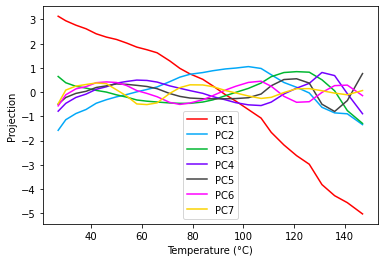

In [5]:
# Let's do PCA on this data and see what the first several PC projections look like
import matplotlib.pyplot as plt
pca = PCA(n_components=.99999)
pca.fit(avg_df)
pcs=pca.transform(avg_df)
fig, ax = plt.subplots()
colors = ['red','#02a8f8','#00b730','#7400ff','#434343','magenta','#fad300']
for i in range(len(colors)):
    ax.plot(tempsC, -1*pcs[:,i], color=colors[i])
ax.legend(['PC'+str(i+1) for i in range(len(colors))])
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Projection')

PC 1 describes a melting trend where contact frequency decreases as temperature increases
PC 2 describes a trend of increasing order with temperature

In [6]:
# The ContactPCA class makes further analysis of the PCs easy
pca_data = ContactPCA(avg_df)

In [14]:
# Now we have a ContactPCA object that makes it easy to analyze the PCs
# If we sort the PCs according to absolute loading score value, we can see which contacts are the most temperature sensitive
# Let's see which residue interactions have the strongest tendency to melt
pca_data.sorted_norm_loadings(1)[['PC1']][:10]

,PC1
A:GLU:263-A:SER:294,1.000000
A:ASP:293-A:TYR:260,0.982246
A:ASP:293-A:GLU:263,0.979721
A:GLN:292-A:HSD:244,0.935146
A:ARG:295-A:ASN:339,0.826282
A:ASN:297-A:ASN:338,0.820465
A:GLY:329-A:LEU:325,0.812708
A:LYS:246-A:SER:294,0.793372
A:GLN:292-A:GLY:296,0.782837
A:ASN:297-A:ASP:293,0.782689


In [15]:
# We can also look at which contacts display the interesting behavior of increasing contact frequency with increasing temperature
pca_data.sorted_norm_loadings(2)[['PC2']][:10]

,PC2
A:LEU:508-A:THR:411,1.000000
A:GLY:638-A:GLY:640,0.881843
A:LEU:639-B:LEU:639,0.848288
A:ARG:712-A:ARG:716,0.746958
A:ARG:319-A:ASP:315,0.741226
A:HSD:471-A:SER:536,0.714558
A:ASP:396-A:THR:399,0.689065
A:PHE:522-A:TYR:564,0.681613
A:ASP:315-A:VAL:317,0.659613
A:GLY:638-B:GLY:638,0.637698


<AxesSubplot:>

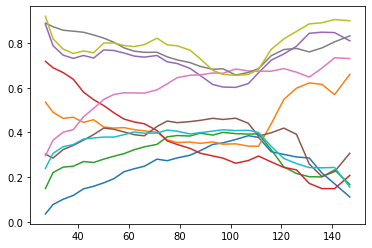

In [9]:
# We can go back to our original contact frequency data and plot these top contacts to see what their sign means
# Let's get the top 5 contacts on PC 2
contacts = pca_data.sorted_loadings(2)[['PC2']].index[:10]
avg_df[contacts].plot(legend=False)

In [10]:
# you can see that being positively correlated on PC 2 means a decreasing contact frequency through the lower temperature range
# Of course it's way more interesting to visualize this data on the protein itself.

In [11]:
from TSenCA.ContactAnalysis.contacts_to_pymol import *
cont_data = ContactFrequencies(avg_df)

In [12]:
to_visualize = []
for pc in range(1,8):
    to_visualize.extend(list(pca_data.sorted_norm_loadings(pc)[f'PC{pc}'].index)[:18])

In [13]:
to_pymol(to_visualize, cont_data, pca_data, 'trpv3_9985_test.pml',pc_range=(1,7))

In [16]:
pca_data.sorted_norm_loadings(6)['PC6'][:10]

A:ALA:474-A:THR:476    1.000000
A:ASP:315-A:VAL:317    0.801471
A:ALA:164-A:ASP:166    0.783047
A:ARG:567-A:THR:699    0.776036
A:ASP:586-A:THR:680    0.743606
A:HSD:477-A:PRO:470    0.722181
A:HSD:471-A:TYR:547    0.688989
A:ASN:242-A:GLN:286    0.682176
A:GLU:682-A:GLY:678    0.654357
A:LEU:473-A:TYR:540    0.650449
Name: PC6, dtype: float64